# Generating Images of Faces with Generative Adversarial Networks
by Manuel Herold and Alexander Lercher

## Agenda
- Project Overview
- Training Data

- GAN Theory
- Chosen GAN Architectures (Lercher)
- Selected Implementation Details (Lercher)
- Results (Lercher)

## Agenda /2
- VAE Theory
- Chosen GAN Architectures (Herold)
- Selected Implementation Details (Herold)
- Results (Herold)

- Conclusion

## Project Overview

- Generation of Images of Human Faces
- Application of Generative Adversarial Network (GAN)
    - Generator: Image Generation
    - Discriminator: Classification as Real or Generated
- Selection of Published GAN Architectures
- Implementation in Python / TensorFlow
- Evaluation of Training Results

### Task Distribution
| Task                       | Team member       | Description                     |
|:---------------------------|:------------------|:--------------------------------|
| Training Data Collection   | Manuel; Alexander | Collection of raw images        |
| Training Data Alignment    | Manuel            | Preparation of images for learning      |
| GAN Training Pipeline      | Alexander         | Training process implementation |
| GAN Reference Architecture | Alexander         | Image generation from [1, 2]       |
| GAN VAE Noise Input        | Manuel            | Image generation from [3]       |

[1] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks; Alec Radford, Luke Metz, Soumith Chintala

[2] High-resolution Deep Convolutional Generative Adversarial Networks; J. D. Curtó, I. C. Zarza, Fernando de la Torre, Irwin King, Michael R. Lyu

[3] Generative Adversarial Networks with Decoder-Encoder Output Noise; Guoqiang Zhong, Wei Gao, Yongbin Liu, Youzhao Yang

## Training Data
- Images of real faces, so the GAN can learn features from them


- Images crawled from model websites
- Images from *Labeled Faces in the Wild*
- Images from *CelebA*


### CelebA Dataset
<img src="http://mmlab.ie.cuhk.edu.hk/projects/CelebA/overview.png" width="50%" />

### Data Preparation

- Images are converted to greyscale (1 channel)
- Image dimensions are cropped to our desired size (256x256)
- Faces are moved to the middle of the cropped image


- Prepared images are combined to batches of size 64
- Batches are stored on disk as numpy arrays (64, 256, 256, 1)

### Reasons for Additional Preparation
- All images without detected face were removed
- Therefore, all training images contain a face in the center


- GAN learns to focus on center 
- Background is less important

## Generative Adversarial Networks

<img src="https://developers.google.com/machine-learning/gan/images/gan_diagram.svg" width="80%" />



### Discriminator Goal
- Classify input images into two classes:
    - fake / generated 
    - real 

- Loss function:
     - $ L(D) = -\frac{1}{2} \mathbb{E}_x [ log (D(x)) ] -\frac{1}{2} \mathbb{E}_z [ log (1 - D(G(z))) ] $

- Theoretical optimum:
    - $D(x)=1$
    - $D(G(z))=0$

Intuitively, the first part optimizes predictions for real data $x$ which should be classified as real, with $D(x)=1$. The second part represents predictions for fake data from the generator which should be classified as fake, with $D(G(z))=0$.

### Generator Goal
- Generation of realistic images
    - based on real training images
    - should fool discriminator

- Loss function:
    - $ L(G) = - \mathbb{E}_z [ log (D(G(z))) ] $

- Theoretical optimum:
    - $D(G(z))=1$
    

### Convolutions
The implemented networks employ two-dimensional convolutions

Discriminator:
- Image as input, eg. (256, 256, 1)
- Convolutions with stride 2 (downsampling)
- Binary classification result as output, eg. real or not real

Generator:
- Noise as input, eg. random vector of size 100
- Transposed convolutions with stride 2 (upsampling)
- Image as output, eg. (256, 256, 1)
    

The ANNs have to learn the actual values for the convolutions.

### Convolution
- Kernel size = 3
- Stride = 2

<img alt="2D Convolution Stride 2"
     src="https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif" 
     width="200" />

### Transposed Convolution
- Kernel size = 3
- Stride = 2

<img alt="2D Transposed Convolution Stride 2"
     src="https://miro.medium.com/max/395/1*Lpn4nag_KRMfGkx1k6bV-g.gif" 
     width="200" />

## Chosen GAN Architectures (Lercher)
- Deep Convolutional GAN (DCGAN)
- High-Resolution Deep Convolutional GAN (HR-DCGAN)

### Deep Convolutional GAN (DCGAN)
- Chains multiple convolutions with stride 2
- Each convolution doubles/ halves the resulting matrix size
- Batch normalization for every layer
    - Except generator output and discriminator input
    - BatchNorm normalizes the values 
    - Helps with gradient flow
- Linear activation functions
    - ReLU for generator
    - LeakyReLU for discriminator
- Adam optimizer with learning rate 0.0002 and momentum 0.5



<img src="lercher/dcgan_generator_architecture.png" width="80%" />

### High-Resolution Deep Convolutional GAN (HR-DCGAN)
- Improvement of DCGAN
- Almost same convolution clain
    - two new layers with stride 1
    - first for generator 
    - last for discriminator
- Exponential activation functions
    - SELU for generator and discriminator
- Same optimizer and hyperparameters



<img alt="HR-DCGAN Architecture"
     src="lercher/hrdcgan_architecture.png" 
     height="90%" />

## Selected Implementation Details (Lercher)
- Implementation was done in Python 3 with TensorFlow
- Object-oriented implementation for better maintainability
- Jupyter Notebooks for training


### Training Data Preprocessing
- Loads all image paths from disk
- Preprocesses individual images as explained previously
- Combines them to batches and yields every batch to the caller directly

Pro:
- Only a subset of training images is loaded into memory

Con:
- The processing has to be done for each epoch

In [ ]:
def get_all_training_images_in_batches(self) -> Iterable[np.ndarray]:
    '''
    Preprocesses all training images and returns them in multiple batches, where one batch is one numpy array.

    :returns: arrays with shape (self.batch_size, self.image_width, self.image_height, 1)
    '''
    current_batch = [] # the current batch to fill

    for image_path in self._load_all_images_from_disk():
        image: Image = Image.open(image_path)
        try:
            image = self._preprocess_image(image)
        except LookupError:
            continue # no face was found in image

        current_batch.append(np.array(image))

        if len(current_batch) == self.batch_size:
            yield self._convert_image_batch_to_training_array(current_batch)
            current_batch = []

    if len(current_batch) > 0:
        yield self._convert_image_batch_to_training_array(current_batch)


### Training Data Preparation /2
- Preprocessed data is stored to disk once
- Then loaded on every epoch

Pro:
- Faster training as images are only processed once

Con:
- Prepared images have to be stored on disk


In [ ]:
def get_all_training_images_in_batches_from_disk(self) -> Iterable[np.ndarray]:
    '''
    Loads preprocessed image arrays from files. 
    Memory load is not that high, as only individual batches are read in.
    The batch size is fixed to 64.

    :returns: same as self.get_all_training_images_in_batches() but faster.
    '''
    if not os.path.exists(self.npy_data_path):
        raise IOError(f"The training arrays folder {self.npy_data_path} does not exist.")

    for _, _, files in os.walk(self.npy_data_path):
        random.shuffle(files)
        for file_ in files:
            yield np.load(os.path.join(self.npy_data_path, file_), allow_pickle=True)


### GAN Training Process
- Training process is implemented once and used for all GAN architectures
- Strategy pattern to add new architectures more easily
- A new network only needs to provide:
    - new architectures
    - noise dimension
    - optimizer hyperparameters



<img alt="HR-DCGAN Architecture"
     src="lercher/gan_strategy_pattern.png" 
     width="40%" />


### Implementation of Loss Functions

In [ ]:
@staticmethod
def discriminator_loss(real_output, generated_output):
    '''The discriminator loss function, where real output should be classified as 1 and generated as 0.'''
    return GAN.bce(tf.ones_like(real_output), real_output) + GAN.bce(tf.zeros_like(generated_output), generated_output)

@staticmethod
def generator_loss(generated_output):
    '''The generator loss function, where generated output should be classified as 0.'''
    return GAN.bce(tf.ones_like(generated_output), generated_output)

### Implementation of Training Steps 
First approach:
- Training of discriminator and generator taking turns
- Using build-in TensorFlow training methods
- eg. training one ANN for 20 iterations while the other is stable


### Implementation of Training Steps /2
Second approach:
- Training of discriminator and generator in parallel
    - Generating the results
    - Calculating the losses
    - Calculating the gradients
    - Updating the weights
- Using a TensorFlow function to execute the training

In [ ]:
@tf.function
def train_step(self, real_data_batch: np.ndarray) -> '(disc_loss, gen_loss)':
    # prepare real data and noise input
    batch_size = real_data_batch.shape[0]
    noise = tf.random.normal([batch_size, self.get_noise_dim()])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Predict images with G
        gen_data = self.generator(noise, training=True)

        # Predict classes with D
        d_real_predicted_labels = self.discriminator(real_data_batch, training=True)
        d_fake_predicted_labels = self.discriminator(gen_data, training=True)

        # Compute losses
        d_loss_value = GAN.discriminator_loss(real_output=d_real_predicted_labels, generated_output=d_fake_predicted_labels)
        g_loss_value = GAN.generator_loss(generated_output=d_fake_predicted_labels)

    # Now that we have computed the losses, we can compute the gradients (using the tapes)
    gradients_of_discriminator = disc_tape.gradient(d_loss_value, self.discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(g_loss_value, self.generator.trainable_variables)

    # Apply gradients to variables
    self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

    return d_loss_value, g_loss_value

### GAN Architectures
- Implemented as Keras Sequential Models
- Two GANs per paper
    - Small version for MNIST handwritten digits with shape (28, 28, 1)
    - Larger version for CelebA facial images with shape (256, 256, 1)


In [ ]:
def build_generator(self):
    noise_shape = (self.get_noise_dim(),)

    model = Sequential([

        # project and reshape
        layers.Dense(7*7*128, use_bias=False, input_shape=noise_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((7, 7, 128)),
        # shape (7, 7, 128)

        # stride 2 -> larger image
        # thiccness 64 -> channels
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        # shape (14, 14, 64)

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
        # shape (28, 28, 1)

    ])

    return model

In [ ]:
def build_discriminator(self):
    img_shape = (28, 28, 1)

    model = Sequential([

        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=img_shape),
        layers.LeakyReLU(alpha=.2),
        # shape (14, 14, 64)

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=.2),
        # shape (7, 7, 128)

        layers.Flatten(),
        layers.Dense(1)
    ])

    return model

## Results (Lercher)
Results are generated by the GANs after 50 epochs with:
- 60,000 MNIST images 
- 50,000 faces from CelebA

For CelebA the architecture was reduced by half, 
as the original architecture took too long on my machine.

### DCGAN
<div>
    <img alt="DCGAN MNIST"
         src="../gan/models/mnist/dcgan/progress.gif"
         style="width: 30%; float: left;"/>
    <img alt="DCGAN Faces"
         src="../gan/models/faces/dcgan_reduced_architecture/progress.gif"
         style="width: 30%; margin-left:20px; float: left;"/>
<div/>

### HR-DCGAN
<div>
    <img alt="HR-DCGAN MNIST"
         src="../gan/models/mnist/hr_dcgan/progress.gif"
         style="width: 30%; float: left;"/>
    <img alt="HR-DCGAN Faces"
         src="../gan/models/faces/hr_dcgan_reduced_architecture/progress.gif"
         style="width: 30%; margin-left:20px; float: left;"/>
<div/>

### Comparison with Existing Networks
Our generator has inferior performance compared to results from the HR-DCGAN paper. 

![HR-DCGAN 150 Epochs](lercher/hrdcgan_150_epochs.png)

![HR-DCGAN 150 Epochs](lercher/hrdcgan_19_epochs_celeba.png)

### Calculation of Fréchet Inception Distance
Measures the distance of feature distributions between real and generated images (lower is better)

$ FID((m,C),(m_w,C_w)) = \left \| m-m_w \right \|^2_2 + Tr(C + C_w - 2(CC_w)^\frac{1}{2}) $

- $(m,C)$ is mean and covariance of generated images
- $(m_w,C_w)$ is mean and covariance of real-world imagesis covariance  
- $Tr(.)$ sums up the diagonal elements of the matrix 

In [ ]:
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    
    # calculate sum squared difference between means
    ssdiff = sum((mu1 - mu2)**2.0)
    
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
        
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

### Fréchet Inception Distance
Features are extracted by Keras' pretrained InceptionV3 model

FID results for a sample size of 2,000 images:

|          | MNIST | CelebA | 
|:---------|:------|:------|
| DCGAN    | 25.0  | 494.8 |
| HR-DCGAN | 27.8  | 565.0 |
| HR-DCGAN* | - | 8.44 |

*) Stated in the paper's results


### Training of Original Architectures with CelebA
Previously:
- Training images were reduced to 50,000
- Image size was reduced to (256, 256, 1)
- Layers were reduced by half, instead with stride 4


New architecture:
- All training images where faces are detected are used
- Image size set to (512, 512, 3)
- All layers were implemented


### Training Original Architectures with CelebA /2
<div>
    <img src="../gan/models/faces/dcgan/progress.gif"
         style="width: 30%; float: left;"/>
    <img src="../gan/models/faces/hr_dcgan/progress.gif"
         style="width: 30%; margin-left:20px; float: left;"/>
<div/>

### Image Generation with our Models
Finally, we provide a short script to create images with our trained generators.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [2]:
# Execute this to avoid internal tf error
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from ipywidgets import interact_manual

# add the project's base dir to interpreter paths
import sys
sys.path.insert(1, '../')
from gan import GAN

# use this hack as Jupyter Notebook 
# cannot create new reference in interact_manual
gan = {'gan': None} 

In [4]:
print("Select Generator:")
@interact_manual
def test(architecture=['dcgan', 'hr_dcgan'], dataset=['mnist', 'faces']):
    gan['gan'] = GAN.import_gan(path=f"../gan/models/{dataset}/{architecture}{'_reduced_architecture' if dataset=='faces' else ''}/")

Select Generator:


interactive(children=(Dropdown(description='architecture', options=('dcgan', 'hr_dcgan'), value='dcgan'), Drop…

In [5]:
import matplotlib.pyplot as plt

@interact_manual
def generate():
    img = gan['gan'].generate()
    plt.imshow((img[0, :,:,0]), cmap='gray')
    plt.axis('off')
    plt.show()

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

## Summary
- Results are promising
    - Outline of face
    - Facial features like eyes, nose, and mouth
    - Different hairstyles
- Results trained on the server got worse again
    - Mode collapse (should be avoided by BatchNorm)
    - Adaption of model architecture or training process
        - Larger number of filters
        - Longer training for single adversary
        - Different hyperparameters

In [78]:
def plot_latent(encoder, decoder):
    '''
    Plots a grid of points in the latent space to check the seemless transition between features.
    '''
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.title('Distribution of images in the latent space')
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(encoder, decoder, data, labels):
    '''
    display a 2D plot of the digit classes in the latent space
    '''
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title('Visualization of the latent space')
    plt.show()


## Autoencoders

Autoencoders map the inputs of the neural network to points of a so-calle "latent space". The dimensionality of the latent space is usually lower than the dimensionality of the input.

![alt text](https://qph.fs.quoracdn.net/main-qimg-3e7385084fb61e6b0288ad79a2440169.webp "Diagram indicating how the AutoEncoder works")

### Applications:
1. __Compression__ ... As the latent space is smaller than the original input size, the latent representation can stored more efficiently.
2. __Anomaly Detection__ ... If the input data used for autoencoders is considered "normal", the autoencoder learns all those normal features during training. If some input deviates from the norm (f.e. a handwritten "A" instead of a number in the example above), the autoencoder will perform worse in reconstructing the image.
3. __Reducing Noise__ ... The model is trained on reconstructing noise-free images. So if noisy images get fed into the autoencoder, there is a high chance in resulting into a reconstruction with substantially less noise.

In [83]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras

from gan.degan_ae2 import AE


# input/output shape = (28x28x1) for the MNIST dataset
# latent space dimensionality = 100
ae = AE((28,28,1),100,summary=False)
ae.import_models("../gan/models/mnist/degan/ae2", force=True, compile=False)

(x_train, y_train), (x_test, _) = keras.datasets.mnist.load_data()

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), 28, 28, 1))

x_train = x_test.astype('float32') / 255.
x_train = x_test.reshape((len(x_test), 28, 28, 1))

latent_representation = ae.encoder(x_test[1].reshape(-1,28,28,1)).numpy()
decoded_image = ae.decoder(latent_representation).numpy()

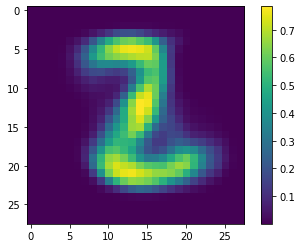

In [76]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plt.imshow(decoded_image.reshape(28,28))
plt.colorbar()

In [ ]:
plt.imshow(latent_representation.reshape(25,4))
plt.colorbar()

In [ ]:
plt.imshow(np.random.normal(size=(25,4)))
plt.colorbar()

## Variational Autoencoders

Regular autoencoders lack regularity in the latent space. There is relation in the distance between two points in the latent space to the similarity of the reconstructed images, the mapping is arbitrary.

![alt text](https://miro.medium.com/max/1000/1*iSfaVxcGi_ELkKgAG0YRlQ@2x.png)

Source: [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

This problem gets tackled by Variational Autoencoders. Instead of mapping the input to a specific point in the latent space, it maps it to a distribution of points. The output of the encoder is a normal distribution over the latent space that can be used to sample points in the same.

![alt text](https://miro.medium.com/max/700/1*Q5dogodt3wzKKktE0v3dMQ@2x.png "Diagram of a VAE")

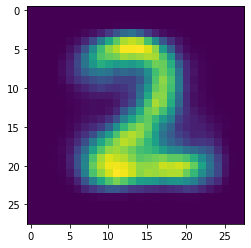

In [74]:
from gan.degan_vae import VAE

latent_dim = 2 # dimensionality of the latent space
load = True    # should stored weights be loaded from the disk?
train = False  # should the model be trained?
export = False # should the weights be exported?

vae = VAE(2, True)
vae.compile(optimizer=keras.optimizers.Adam())

reconstructed_image = vae.decoder(
    vae.encoder(x_test[1].reshape((-1,28,28,1)))
    ).numpy().reshape(28,28)

plt.imshow(reconstructed_image)

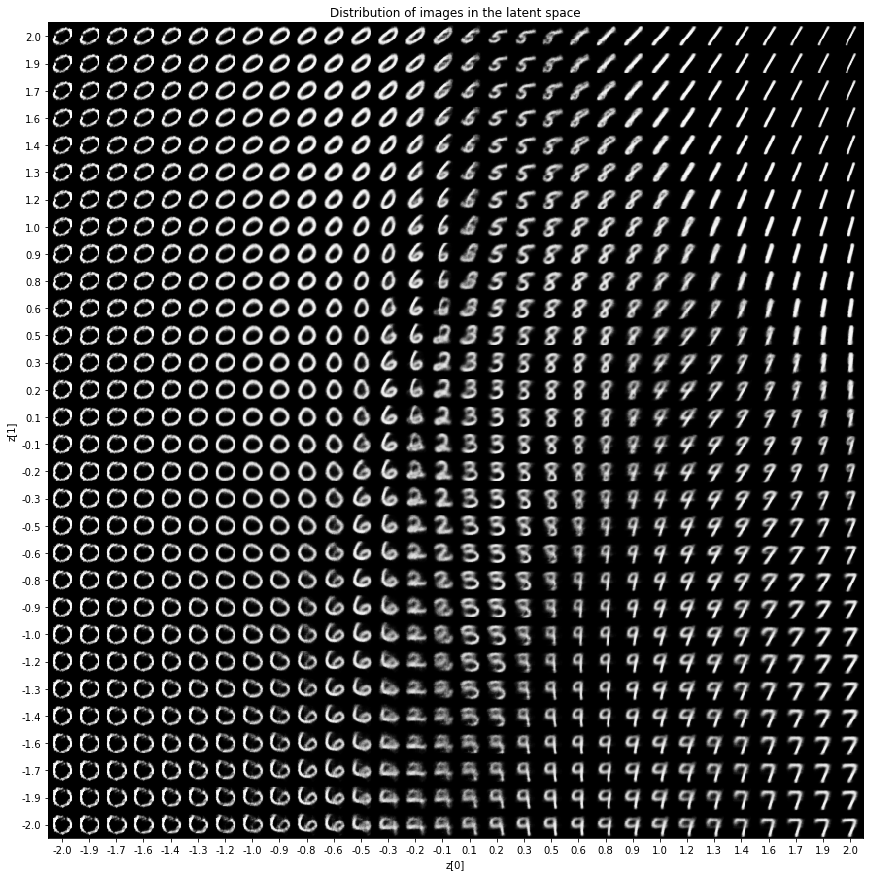

In [79]:
plot_latent(vae.encoder, vae.decoder)

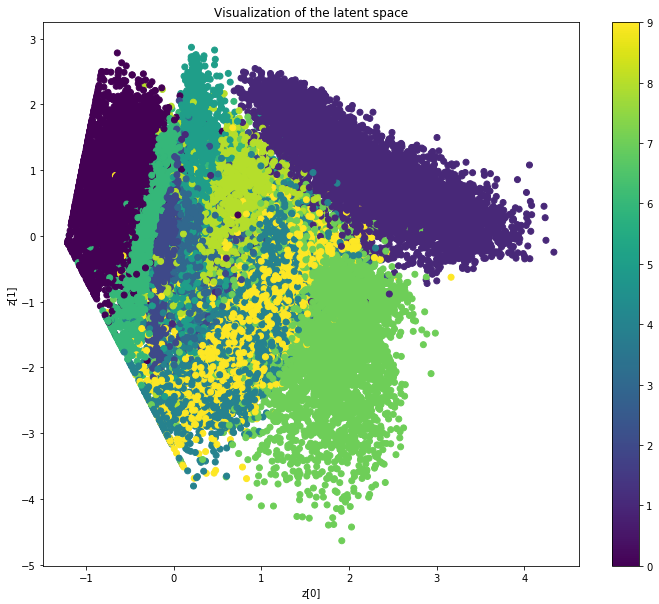

In [85]:
(x_train, y_train), (x_test, _) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae.encoder, vae.decoder, x_train, y_train)

## 7. Conclusion
## Chosen GAN Architectures (Herold)
- Decoder Encoder Generative Adversarial Network (DEGAN)

## Decoder Encoder Generative Adversarial Network (DEGAN)
- Use *structured* noise instead of white noise
- Hypothesis: The noise contains information about the base image which helps in training the generator
- Experiment: The newly generated noise makes the output worse than the training with normal distributed input noise

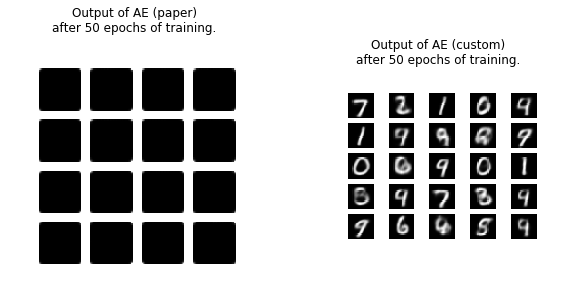

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(10,20))

img = mpimg.imread('herold/ae_paper_epoch_50.png')
ax[0].imshow(img)
ax[0].set_title("Output of AE (paper)\nafter 50 epochs of training.")
ax[0].axis("off")

img = mpimg.imread('herold/ae_custom_epoch_50.png')
ax[1].imshow(img)
ax[1].set_title("Output of AE (custom)\nafter 50 epochs of training.")
ax[1].axis("off")
pass

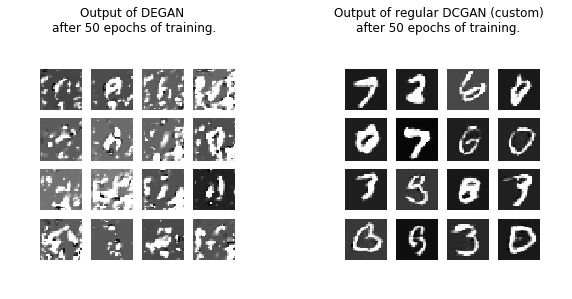

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10,20))

img = mpimg.imread('herold/degan_epoch_50.png')
ax[0].imshow(img)
ax[0].set_title("Output of DEGAN \nafter 50 epochs of training.")
ax[0].axis("off")

img = mpimg.imread('herold/dcgan_epoch_50.png')
ax[1].imshow(img)
ax[1].set_title("Output of regular DCGAN (custom)\nafter 50 epochs of training.")
ax[1].axis("off")
pass

## Conclusion
Overall, our results after just 50 epochs look promising especially for the DCGAN. The center of generated images already contains the outline of a round face including eyes, nose and mouth. Even hair is already generated in various hairstyles. 

The results from our normal DCGAN look better than from our HR-DCGAN. 
I assume this has to do with the size of training images, as 256x256x1 is not quite high-resolution. In their paper, the authors used training images of size 512x512x3 [4] which I regarded as similar size, as this would only add a single convolution layer multiplying or dividing our current resolution by 2x2 again.

In future work, we would like to train the GAN on a server with the original network architectures and the whole range of 200,000 celebrity faces. This should give more variety and allows the discriminator to learn when a face is _consistent_ because current faces contain a mixture of real faces, e. g. different hairstyles or two different eyes.
Then, we could also add color channels which increases the size per image by an additional factor of 3. <br />
-> results are still bad, as mode collapse happened 

### Herold

The DEGAN implementation did not yield the results proposed in the paper at all. The paper itself showed many flaws, like omitting the hyper parameters in the description of the network layouts or stating that a VAE was used while a regular AE was described in the implementation table.

The testrun on the MNIST dataset did not produce an ouput close to the quality of the original dataset, thus the test on the CelebA dataset was omitted.